In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import multi_gpu_model

import scipy.signal

import astra

# Create a MirroredStrategy.
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 2


In [4]:
"""
UTILITIES:

Those functions serves as utilities for the rest of the program.
"""

def read_img(path):
    return np.load(path)


def get_name_list(path):
    import os
    n_list = []
    for patient in os.listdir(path):
        count = 0
        for slice_id in os.listdir(path + patient):
            n_list.append(path + patient + '/' + str(count) + '.npy')
            count += 1
    
    return n_list


# SSIM Function: needed to compute the metrics
def ssim_loss(y_true, y_pred):
    return tf.math.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

In [5]:
"""
LOAD PATHs:

Those functions serves to load input and output paths, as lists of images name.
"""
x_path = np.array(get_name_list('./SGP_180_180/'))
y_path = np.array(get_name_list('./FDCT_180_180/'))

# Order them to couple (x, y)
x_path.sort()
y_path.sort()

# Shuffle
idx = np.arange(len(x_path))
np.random.shuffle(idx)

x_path = x_path[idx]
y_path = y_path[idx]

In [6]:
"""
Define the ResUNet Model, following the paper A Residual Dense U-Net Neural Network for Image Denoising.

input_shape -> Tuple, input dimension
n_scales -> Number of downsampling
conv_per_scale -> Number of convolutions for each scale
init_conv -> Number of convolutional filters at the first scale
"""

def get_resunet(input_shape, n_scales, conv_per_scale, init_conv=64):
    n_ch = init_conv
    skips = []

    x = layers.Input(input_shape)
    h = x

    # ANALYSIS
    for scale in range(n_scales):
        for c in range(conv_per_scale):
            h = layers.Conv2D(n_ch, 3, 1, padding='same')(h)
            h = layers.BatchNormalization()(h)
            h = layers.ReLU()(h)
        
        skips.append(h)
        h = layers.MaxPooling2D()(h)
        n_ch = n_ch * 2

    # FILTERING
    for c in range(conv_per_scale):
        h = layers.Conv2D(n_ch, 3, 1, padding='same')(h)
        h = layers.BatchNormalization()(h)
        h = layers.ReLU()(h)
    
    n_ch = n_ch // 2
    h = layers.Conv2DTranspose(n_ch, 3, 1, padding='same')(h)
    h = layers.UpSampling2D()(h)

    # SYNTHESIS
    for scale in range(n_scales):
        h = layers.Concatenate()([h, skips.pop(-1)])
        for c in range(conv_per_scale):
            h = layers.Conv2D(n_ch, 3, 1, padding='same')(h)
            h = layers.BatchNormalization()(h)
            h = layers.ReLU()(h)
    
        if scale < n_scales-1:
            n_ch = n_ch // 2
            h = layers.Conv2DTranspose(n_ch, 3, 1, padding='same')(h)
            h = layers.UpSampling2D()(h)

    y = layers.Conv2D(input_shape[-1], 1, 1, padding='same', activation='tanh')(h)
    y = layers.Add()([x, y])
    return models.Model(x, y)


"""
3L-SSN -> The simple Convolutional Neural Network proposed in out layer.

input_shape -> Tuple, input dimension
"""
def get_3lSSN(input_shape):
    x = layers.Input(input_shape)
    
    # Synthesis Layer
    h = layers.Conv2D(128, 9, 1, padding='same')(x) 
    h = layers.ReLU()(h)
    
    # Sparsifier Layer
    h = layers.Conv2D(64, 3, 1, padding='same')(h)
    h = layers.ReLU()(h)
    
    # Analysis Layer
    y = layers.Conv2D(1, 5, 1, padding='same')(h)
    return models.Model(x, y)


# Load the model
with strategy.scope():
    INPUT_SHAPE = (512, 512, 1)
    N_SCALES = 4
    CONV_PER_SCALE = 2
    INIT_CONV = 64
    MODEL_TYPE = 'resunet' # or '3lssn'
    
    if MODEL_TYPE == 'resunet':
        model = get_resunet(INPUT_SHAPE, N_SCALES, CONV_PER_SCALE, INIT_CONV)
    elif MODEL_TYPE == '3lssn':
        model = get_3lSSN(INPUT_SHAPE)  
    
    # Define the Optimizer
    initial_learning_rate = 1e-3
    lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
        initial_learning_rate,
        decay_steps=1e5,
        end_learning_rate=1e-5)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), clipnorm=5,
                  loss='mse',
                  metrics=[ssim_loss, 'mse'])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [7]:
"""
Define a Sequence that loads the data. Indeed, due to memory limitations, it is impossible to load in RAM the whole dataset.
For this reason, we will load it batch by batch.
"""
class Data2D(Sequence):
    def __init__(self, x_path, y_path, batch_size):
        self.batch_size = batch_size
        self.x_path, self.y_path = x_path, y_path

        self.N = len(self.x_path)
        
    def __len__(self):
        'Number of batches per epoch'
        return int(self.N // self.batch_size)
    
    def __getitem__(self, idx):
        'Generate one batch of data'

        x = np.zeros((self.batch_size, 512, 512, 1))
        y = np.zeros((self.batch_size, 512, 512, 1))

        for i in range(self.batch_size):
            x[i, :, :, 0] = np.load(x_path[i + self.batch_size*idx])
            y[i, :, :, 0] = np.load(y_path[i + self.batch_size*idx])
        
        x = x.astype('float32')
        y = y.astype('float32')
            
        return x, y

    
# Initialize the DataLoader.
dataloader = Data2D(x_path, y_path, 8)

In [9]:
"""
TRAINING!
"""
TRAIN = True
FILE_NAME = './model_weights/pirange_60views_resunet.h5'
if TRAIN:
    model.fit(dataloader, epochs=50)
    model.save_weights(FILE_NAME)
    
else:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
    model.load_weights(FILE_NAME)

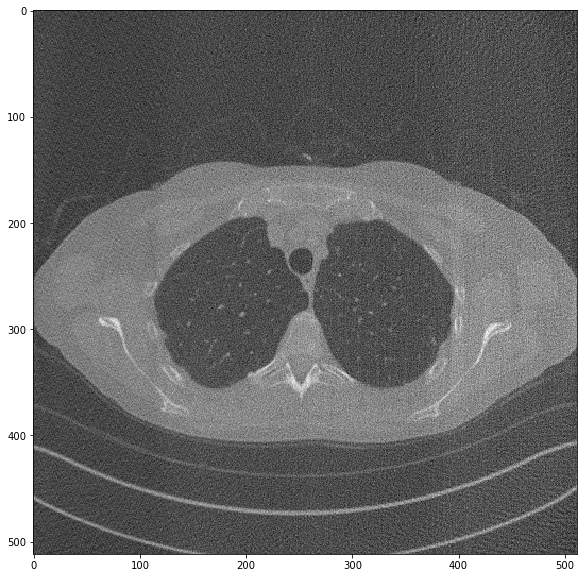

Rel. Err. 0.9936656936734328
SSIM: 0.2558900278329087
Min/Max: -0.0027361729 0.0071738623


/home/davide.evangelista/anaconda3/envs/tomo/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
/home/davide.evangelista/anaconda3/envs/tomo/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  **kwargs)


In [10]:
"""
EVALUATION:

Here we will evaluate the results from our model. This first block measures the quality of a specific image, the following one
will measure the mean metric in the dataset
"""

CORR_IMAGE = './Test/C081_FPB_Test1/0.npy'
TRUE_IMAGE = './Test/C081/0.npy'

x_LD = np.load(CORR_PATH)
x_FD = np.load(TRUE_PATH)

x_to_clean = np.zeros((2, 512, 512, 1))
x_to_clean[0, :, :, 0] = x_LD

x_recon = model.predict(x_to_clean)[0]
x_recon = x_recon.reshape((512, 512))

plt.figure(figsize=(10, 10))
plt.imshow(x_recon)
plt.gray()
plt.show()

from skimage.measure import compare_ssim as ssim
print('Rel. Err.', np.linalg.norm(x_FD - x_recon, 'fro') / np.linalg.norm(x_FD, 'fro'))
print('SSIM:', ssim(x_recon, x_FD))
print('Min/Max:', x_recon.min(), x_recon.max())

In [22]:
"""
EVALUATION: Refer to the cell above for informations.
"""
import os
from skimage import filters
from skimage.metrics import structural_similarity as ssim

import image_similarity_measures
from image_similarity_measures.quality_metrics import rmse, psnr, fsim, issm, uiq

def evaluate(x_true, x_corr, metric):
    N = x_true.shape[0]
    m = 0
    for i in range(N):
        try:
            m += metric(x_true[i, :, :, 0], x_corr[i, :, :, 0])
        except:
            m += metric(x_true[i, :, :, :], x_corr[i, :, :, :])
    return m / N

def get_test_name(path):
    n_list = []
    for name in os.listdir(path):
        n_list.append(path + name)
        
    return n_list

def relative_error(x_true, x_corr):
    return np.linalg.norm(x_true - x_corr, 'fro') / np.linalg.norm(x_true, 'fro')


true_path = './Test/C081/'
corr_path = './Test/C081_SGP_Test4/'

true_path = get_test_name(true_path)
corr_path = get_test_name(corr_path)

true_path.sort()
corr_path.sort()

x_true = np.zeros((len(true_path), 512, 512, 1))
x_corr = np.zeros((len(corr_path), 512, 512, 1))

for i in range(len(true_path)):
    x_true[i, :, :, 0] = read_img(true_path[i])
    x_corr[i, :, :, 0] = read_img(corr_path[i])


x_corr = model.predict(x_corr, batch_size=16)

import matplotlib as mpl
mpl.image.imsave('SGP_Test4.png', x_corr[0, :, :, 0], cmap='gray')

print('SSIM:', evaluate(x_true, x_corr, ssim))
print('PSNR:', evaluate(x_true, x_corr, psnr))   
print('Rel. Err.:', evaluate(x_true, x_corr, relative_error))

1.0
1.0


"\nprint('SSIM:', evaluate(x_true, x_corr, ssim))\nprint('FSIM:', evaluate(x_true, x_corr, fsim))\nprint('PSNR:', evaluate(x_true, x_corr, psnr))   \nprint('Rel. Err.:', evaluate(x_true, x_corr, relative_error))\n"